In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import confusion_matrix, roc_curve, auc, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

%matplotlib inline

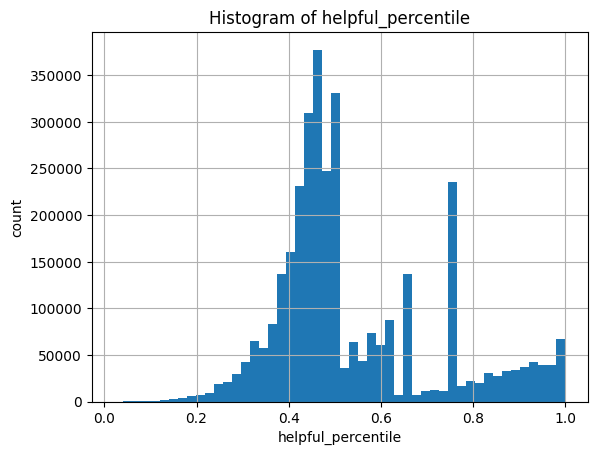

In [3]:
df = pd.read_pickle("df_processed_sentiment.pkl")
df = df.drop(columns=['asin', 'images_meta', 'categories', 'description', 'videos'])
df["helpful_percentile"] = df.groupby("parent_asin")["helpful_vote"].rank(pct=True)
df["is_helpful"] = (df["helpful_percentile"] >= 0.60).astype(int)
cond = (df['helpful_percentile'] == 1.0) & (df['helpful_vote'] < 5)
df = df.loc[~cond].reset_index(drop=True)

ax = df['helpful_percentile'].hist(bins=50)
ax.set_xlabel('helpful_percentile')
ax.set_ylabel('count')
ax.set_title('Histogram of helpful_percentile')
plt.show()

In [4]:
df_sampled = pd.DataFrame()
for category in ['All Beauty', 'AMAZON FASHION', 'Appliances', 'Health & Personal Care']:
    df_category = df[df['main_category'] == category]
    df_helpful = df_category[df_category['is_helpful'] == 1].sample(n=100000, replace=True)
    df_not_helpful = df_category[df_category['is_helpful'] == 0].sample(n=100000, replace=True)
    df_sampled = pd.concat([df_sampled, df_helpful, df_not_helpful], ignore_index=True)


In [5]:
df = df_sampled.copy()

In [6]:
print("Is helpful:", len(df_sampled[df_sampled['is_helpful'] == 1]))
print("Is not helpful:", len(df_sampled[df_sampled['is_helpful'] == 0]))

Is helpful: 400000
Is not helpful: 400000


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=["is_helpful"]), df["is_helpful"], test_size=0.3)
dropping_list = ['title_data', 'text', 'helpful_vote', 'title_meta', 'average_rating', 'rating_number', 'features', 'store', 'details', 'helpful_percentile', 'timestamp']
X_train = X_train.drop(columns=dropping_list)
X_test = X_test.drop(columns=dropping_list)
X_train = X_train.drop(columns=['user_id'])
X_test = X_test.drop(columns=['user_id'])

cols = ['parent_asin','main_category', 'sentiment']

# convert to pandas string dtype for both train and test
X_train[cols] = X_train[cols].astype('category')
X_test[cols] = X_test[cols].astype('category')

# verify
X_train[cols].dtypes, X_test[cols].dtypes


(parent_asin      category
 main_category    category
 sentiment        category
 dtype: object,
 parent_asin      category
 main_category    category
 sentiment        category
 dtype: object)

In [15]:
X_train = X_train.drop(columns=['parent_asin', 'main_category', 'sentiment'])
X_test = X_test.drop(columns=['parent_asin', 'main_category', 'sentiment'])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.


Confusion Matrix:
[[84986 34938]
 [61295 58781]]


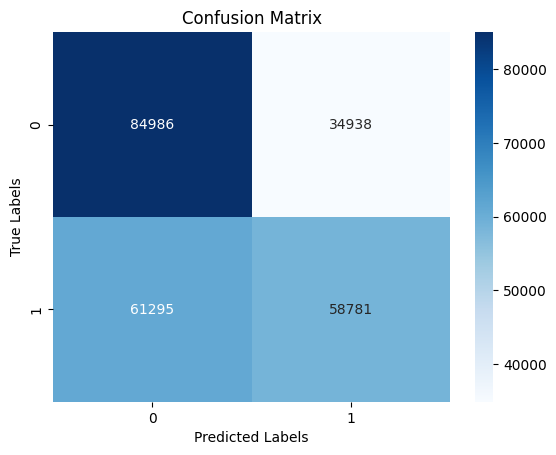

AUC Score: 0.6359


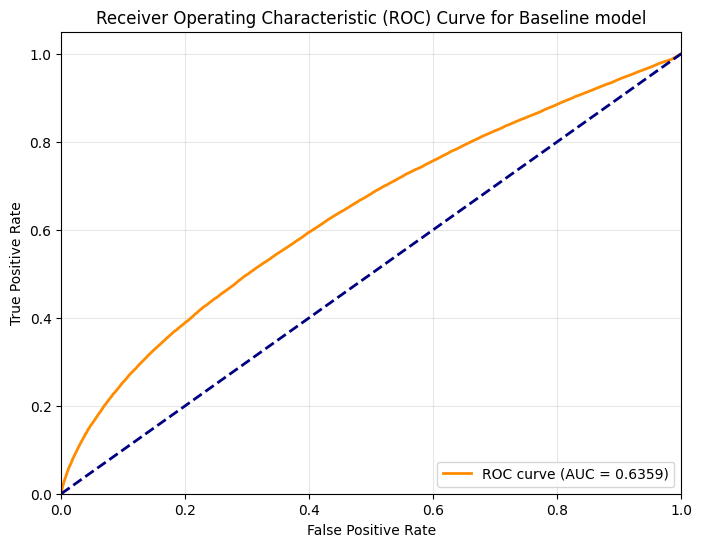

In [16]:
#Baseline 

lr_model = LogisticRegression(max_iter=1000, n_jobs=-1, verbose=1)
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)
y_proba = lr_model.predict_proba(X_test)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Baseline model')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.1s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.


Random Forest Classifier Accuracy: 0.6026416666666666


[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.2s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.1s


Confusion Matrix:
[[86681 33243]
 [62123 57953]]


[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.7s finished


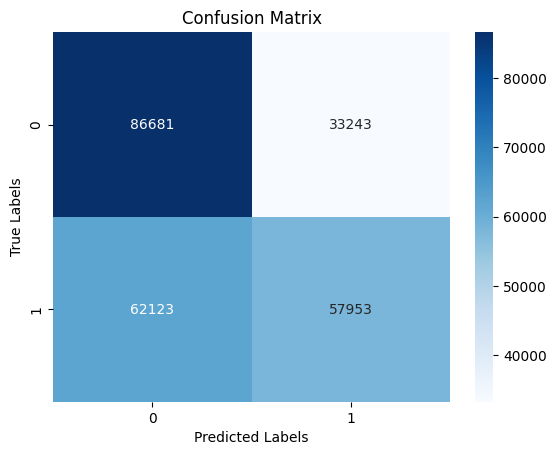

AUC Score: 0.6390


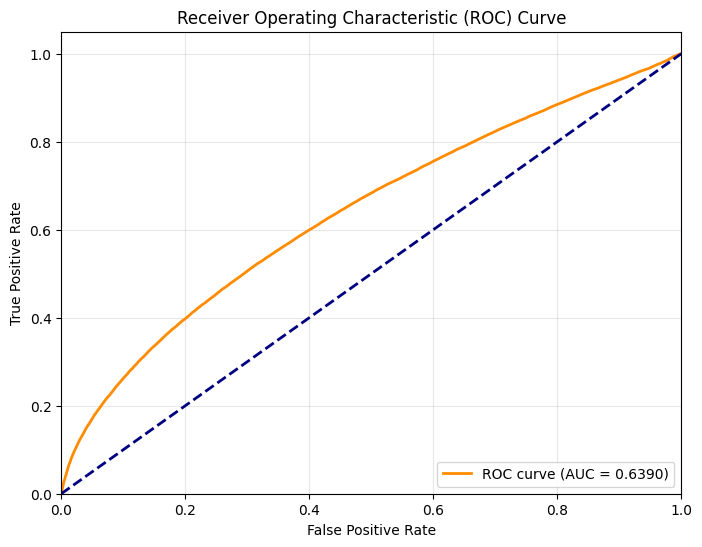

In [17]:
#RF Base
clf = RandomForestClassifier(n_jobs=-1, verbose=True)
clf.fit(X_train, y_train)

# print score of clf on X_test and y_test
print("Random Forest Classifier Accuracy:", clf.score(X_test, y_test))

# Predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]  # for ROC/AUC, need probabilities for the positive class

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

c:\Users\Niels\anaconda3\envs\thesis\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:54:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Confusion Matrix:
[[83928 35996]
 [59010 61066]]


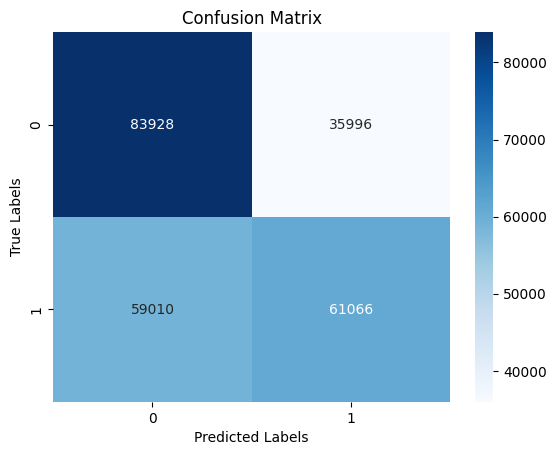

AUC Score: 0.6435


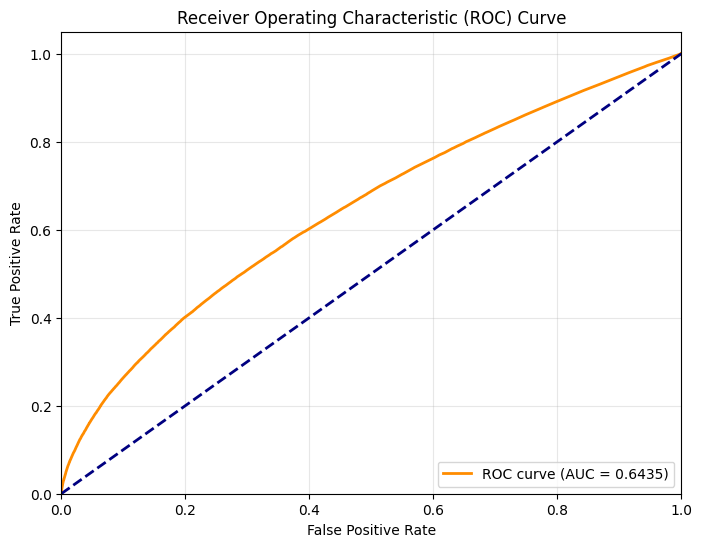

In [18]:
#XGBoost Base
n_estimators = 100

model = xgb.XGBClassifier(
    n_estimators=n_estimators,
    tree_method='hist',        # use efficient histogram algorithm
    predictor='auto',          # auto-detect best predictor (GPU if available)
    enable_categorical=True,
    eval_metric='auc',
    verbosity=1,
    n_jobs=-1
    # callbacks=[TQDMProgressBar(total_rounds=n_estimators)]
)

# Train the model
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]  # for ROC/AUC, need probabilities for the positive class

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()

Iteration 1, loss = 0.66698772
Validation score: 0.602464
Iteration 2, loss = 0.66223958
Validation score: 0.602179
Iteration 3, loss = 0.66074611
Validation score: 0.603732
Iteration 4, loss = 0.65977977
Validation score: 0.603482
Iteration 5, loss = 0.65938263
Validation score: 0.604054
Iteration 6, loss = 0.65905867
Validation score: 0.603643
Iteration 7, loss = 0.65880755
Validation score: 0.603911
Iteration 8, loss = 0.65872668
Validation score: 0.605696
Iteration 9, loss = 0.65862095
Validation score: 0.604214
Iteration 10, loss = 0.65852887
Validation score: 0.603839
Iteration 11, loss = 0.65846975
Validation score: 0.604339
Iteration 12, loss = 0.65848988
Validation score: 0.604411
Iteration 13, loss = 0.65846728
Validation score: 0.604732
Iteration 14, loss = 0.65840461
Validation score: 0.604286
Iteration 15, loss = 0.65838498
Validation score: 0.604714
Iteration 16, loss = 0.65839853
Validation score: 0.604625
Iteration 17, loss = 0.65831328
Validation score: 0.604750
Iterat

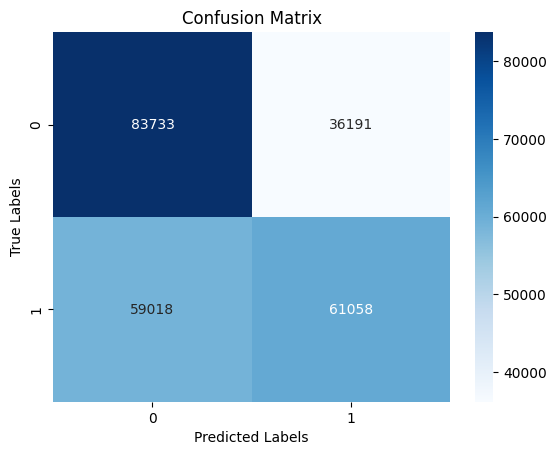

AUC Score: 0.6425


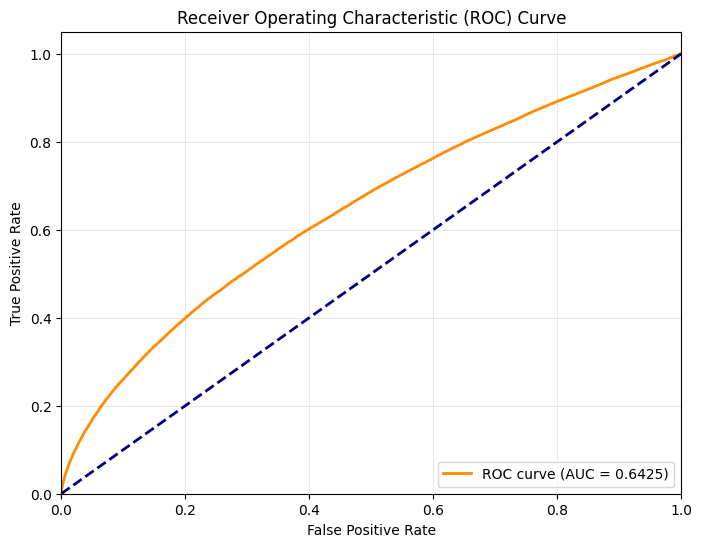

In [19]:
#MLP Base
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

mlp_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    max_iter=500,
    activation='relu', 
    solver='adam', 
    random_state=42,
    verbose=True,
    early_stopping=True
)

mlp_model.fit(X_train, y_train)

# --- 4. Evaluation and Prediction (Mirroring your original pattern) ---
y_pred = mlp_model.predict(X_test)
y_proba = mlp_model.predict_proba(X_test)[:, 1]

# --- Confusion Matrix ---
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# --- ROC Curve and AUC ---
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

print(f"AUC Score: {roc_auc:.4f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.show()
